Guided modes in 1+1D Systems (Task_1,Part_1):

In [11]:
# Importing different libraries
import numpy as np
import scipy.sparse as sps
from scipy.sparse.linalg import eigs
from scipy.sparse import diags
import matplotlib.pyplot as plt

In [12]:
def guided_modes_1DTE(prm, k0, h):
      """Computes the effective permittivity of a TE polarized guided eigenmode.
    All dimensions are in µm.
    Note that modes are filtered to match the requirement that
    their effective permittivity is larger than the substrate (cladding).
    
    Parameters
    ----------
    prm : 1d-array
        Dielectric permittivity in the x-direction
    k0 : float
        Free space wavenumber
    h : float
        Spatial discretization
    
    Returns
    -------
    eff_eps : 1d-array
        Effective permittivity vector of calculated modes
    guided : 2d-array
        Field distributions of the guided eigenmodes
    """

In [13]:
#1D Parameters
grid_size     = 120         # µm
number_points = 601
h             = grid_size/(number_points - 1)# spatial step size
lam           = 0.78        # µm (wavelength)
k0            = 2*np.pi/lam
e_substrate   = 2.25
delta_e       = 1.5e-2
w             = 15.0        # width of Gaussian core
xx            = np.linspace( -grid_size/2, grid_size/2, number_points )# Coordinate grid
prm         = e_substrate + delta_e * np.exp(-(xx/w)**2) # Permittivity profile (Gaussian core)

This task involves numerically solving the Helmholtz equation for TE-polarized guided modes in a 1D slab waveguide using a second-order finite-difference (FD) method. 
The goal is to compute the effective permittivities and the corresponding electric field distributions of the guided modes.
We start with the Helmholtz equation in 1D for a TE-polarized wave:

We solve the 1D Helmholtz equation:
$$
\left( \frac{d^2}{dx^2} + k_0^2 \, \varepsilon(x) \right) E_0(x) = k_0^2 \, \varepsilon_{\text{eff}} \, E_0(x)
$$

for a TE‐polarized slab (with PEC boundaries at the ends). Discretizing on a uniform grid \(x_j\), \(j=1,\dots,N\), with spacing \(h\), the second derivative becomes

$$
\frac{E_{j+1} - 2\,E_{j} + E_{j-1}}{h^2}
\;+\; k_0^2\,\varepsilon_j\,E_j
\;=\; k_0^2\,\varepsilon_{\mathrm{eff}}\,E_j\,.
$$
We discretize this into an eigenvalue problem:
$$
A E = \varepsilon_{\text{eff}} E
$$
Where A is a tridiagonal matrix with:

- **Main‐diagonal:**

  $$
  A_{j,j} \;=\; -\frac{2}{h^2} \;+\; k_0^2\,\varepsilon_j.
  $$

- **First off‐diagonals:**

  $$
  A_{j,j\pm 1} \;=\; \frac{1}{h^2}.
  $$

(Everything else is zero.)



In [14]:
# Matrix Building and solving eigenvalue problem
# Main and off diagonals for Helmholtz operator: A E = ε_eff E

main_diag = (-2 / h**2) + (k0**2) * prm
off_diag = np.ones(number_points - 1) / h**2

# Sparse tridiagonal matrix (finite difference)
A = diags([off_diag, main_diag, off_diag], offsets=[-1, 0, 1], format='csr')

#Solve eigenvalue problem 
num_modes = 100
eigvals, eigvecs = eigs(A, k=num_modes, which='LR')  # LR = Largest Real part

# Process eigenvalues: ε_eff = eigval / k0^2
eigvals = np.real(eigvals)
eff_eps = eigvals / k0**2

In [15]:
# Sorting and filtering guided modes: ε_eff > ε_substrate
sorted_idx = np.argsort(eff_eps)[::-1] #returns an array of indices that would sort eff_eps in ascending order.
eff_eps = eff_eps[sorted_idx]#Re‐orders the eff_eps array so that it’s now in descending order
eigvecs = np.real(eigvecs[:, sorted_idx])# re‐orders those columns in the same descending‐ε_eff order.
guided_mask = eff_eps > e_substrate 
eff_eps = eff_eps[guided_mask]
guided_modes = eigvecs[:, guided_mask]

# Normalizing each mode
for i in range(guided_modes.shape[1]):
    guided_modes[:, i] /= np.sqrt(np.trapz(np.abs(guided_modes[:, i])**2, xx))

In [16]:
# Output results
print("Effective Permittivities (ε_eff) of Guided Modes:")
for i, eps in enumerate(eff_eps):
    print(f"Mode {i+1}: ε_eff = {eps:.6f}")
    

Effective Permittivities (ε_eff) of Guided Modes:
Mode 1: ε_eff = 2.264012
Mode 2: ε_eff = 2.262090
Mode 3: ε_eff = 2.260277
Mode 4: ε_eff = 2.258576
Mode 5: ε_eff = 2.256992
Mode 6: ε_eff = 2.255532
Mode 7: ε_eff = 2.254203
Mode 8: ε_eff = 2.253014
Mode 9: ε_eff = 2.251978
Mode 10: ε_eff = 2.251113
Mode 11: ε_eff = 2.250450
Mode 12: ε_eff = 2.250045


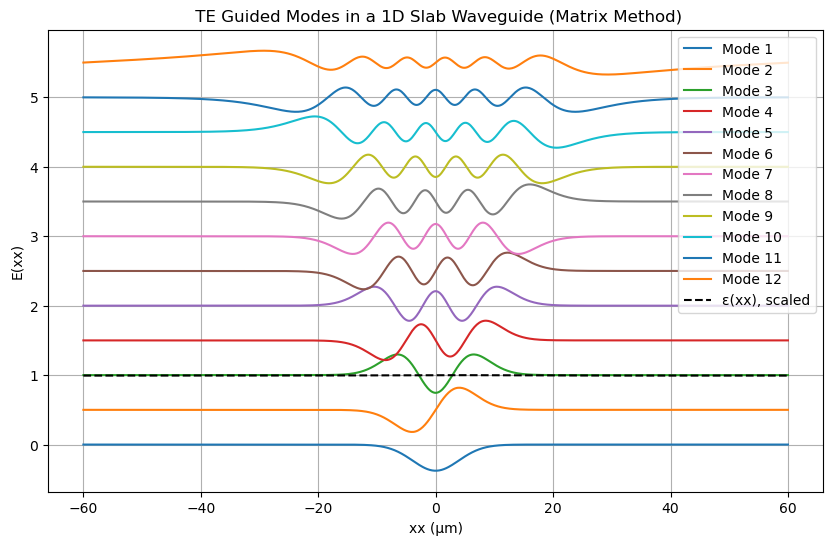

In [17]:
# Plotting Field profile of guided modes
plt.figure(figsize=(10, 6))
for i in range(guided_modes.shape[1]):
    plt.plot(xx, guided_modes[:, i] + i*0.5, label=f"Mode {i+1}")

plt.plot(xx, prm/np.max(prm), 'k--', label='ε(xx), scaled')
plt.title(" TE Guided Modes in a 1D Slab Waveguide (Matrix Method)")
plt.xlabel("xx (µm)")
plt.ylabel("E(xx)")
plt.grid(True)
plt.legend()
plt.show()
    